In [1]:
import cv2 as cv
import cv2
from os import listdir
import math
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import pandas as pd
from scipy import optimize
from tqdm import tqdm
import seaborn as sns
import dlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cv2.__version__

'4.1.2'

In [3]:
np.__version__

'1.18.5'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_dir = 'drive/My Drive/Dr Chao/notebooks/'
# file_dir = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Setup

In [ ]:
# haarcascade_path = '../outside_sources/haarcascade/'
# sripts_path = '../sripts/facial_landmark/'
# raw_data_path = '../data/raw/full/'
# original_raw_data_path = '../data/raw/full_orig/'
# labels_path = '../data/labels/'
# output_img_path = '../data/final_outcome/'
# model_path = '../models/'

## Parse the labeled data from Dr. Liu and prepare testing & validation set

In [ ]:
df_img_info = pd.read_csv(file_dir + '../data/processed/df_img_info.csv')
df_img_info.head()

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0
2,2MR10489169120318-374.87.JPG,3.jpg,1,1,1,0,0,0,0
3,2DM15140817020618-374.33.JPG,4.jpg,1,0,0,0,0,0,1
4,2FM16841546011618-374.33.JPG,5.jpg,0,0,0,0,0,1,1


In [ ]:
df_img_info = pd.read_csv(file_dir + '../data/processed/df_img_info.csv')

labeled_data_dir = file_dir + '../data/processed/left_akg_all/'
lebel_file_dir = file_dir + '../data/labels/cl/'
all_testing_img = []
for label in listdir(lebel_file_dir):
    tmp_name = label.replace('_left.txt', '.JPG')
    tmp_df = df_img_info.query('original_name == "' + tmp_name + '"')
    if tmp_df.shape[0] == 0:
        print('Something wrong with:', label)
        continue
    orderred_img_idx = int(tmp_df.orderred_name.iloc[0].replace('.jpg', ''))
    all_testing_img.append(orderred_img_idx)
print(len(all_testing_img))

100


# Preprocessing the images

### Convert the file names, uncommon if files are not numberred

In [ ]:
# curr_file_count = 0
# for filename in listdir(raw_data_path):
#     try:
#         cv2.imread(original_raw_data_path + filename)
#         curr_file_count += 1
#     except:
#         continue
# print('Currently have:', curr_file_count, 'file(s) as raw data.')
# # count = curr_file_count + 1
# count = 1

# mapping_from_old = []
# for filename in listdir(original_raw_data_path):
#     try:
#         img = cv2.imread(original_raw_data_path + filename)
#     except:
#         print('[ERROR] Cannot read file:', filename)
#         continue
#     cv2.imwrite(raw_data_path + str(count) + '.jpg', img) 
#     mapping_from_old.append({
#         'original_name': filename,
#         'orderred_name': str(count) + '.jpg'
#     })
#     count += 1

In [ ]:
list_of_files = listdir(raw_data_path)
print('Count of images:', len(list_of_files))

Count of images: 269


In [ ]:
# df_img_info = pd.DataFrame(mapping_from_old)
# df_img_info.to_csv('../data/labels/df_img_info.csv', index = False)
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')
df_img_info.head()

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0
2,2MR10489169120318-374.87.JPG,3.jpg,1,1,1,0,0,0,0
3,2DM15140817020618-374.33.JPG,4.jpg,1,0,0,0,0,0,1
4,2FM16841546011618-374.33.JPG,5.jpg,0,0,0,0,0,1,1


In [ ]:
df_img_info.shape

(269, 9)

## Check if the raw data is ready

In [ ]:
ready = False
for file in listdir(raw_data_path):
    if 'png' in file or 'jpg' in file or 'JPG' in file:
        ready = True
        break
if ready:
    print('[SETUP] Data is ready!')
else:
    print('[SETUP] Data is NOT ready!')

[SETUP] Data is ready!


# Detect Eyes
## Step1: Use OpenCV CascadeClassifier

In [ ]:
import copy

In [ ]:
def detect_eye(directory, filename):
    '''
    input:
        directory: directory to the input image (in RGB)
        filename: name of the file
    output:
        img1: image segmentation of one of an eye (type: np.ndarray)
        img2: image segmentation of another eye (type: np.ndarray)
        outpue: original image with the rectangle plotted on the segmented areas
    '''
    # 1. Readin the image and return if there is an error
    print('=================================')
    print('Now Processing:', filename + '...')
    try:
        gray = cv2.imread(directory + filename, 0)
        output = cv2.imread(directory + filename, 0)
    except:
        print(filename, 'is not an image!')
        return -1, -1, -1
    
    # 2. Processing image - detect eyes using CascadeClassifier
    gray = cv2.medianBlur(gray, 7)
#     gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    # [OLD WAY]
    eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(gray)
    if len(eyes) < 2:
        print('[Error!] Stupit classifier!!!')
        return -1, -1, -1
    # Pick the two "eyes" with largest sizes
    eyes = sorted(eyes, key = lambda x: x[2] + x[3], reverse = True)[:2]
    # Sort the "eyes" by their x position
    eyes = sorted(eyes, key = lambda x: x[0], reverse = False)  
    # 3. Crop the original image and return the two eye segments
    result = []
    for (ex,ey,ew,eh) in eyes:
        eye = output[ey-25:ey + eh + 25, ex - 25:ex + ew + 25]
        result.append(eye)
    
    print('Done processing:', filename + '!')
    return result[0], result[1], output

In [ ]:
# def detect_eye(directory, filename):
#     '''
#     input:
#         directory: directory to the input image (in RGB)
#         filename: name of the file
#     output:
#         img1: image segmentation of one of an eye (type: np.ndarray)
#         img2: image segmentation of another eye (type: np.ndarray)
#         outpue: original image with the rectangle plotted on the segmented areas
#     '''
#     # 1. Readin the image and return if there is an error
#     print('=================================')
#     print('Now Processing:', filename + '...')
#     try:
#         gray = cv2.imread(directory + filename, 0)
#         output = cv2.imread(directory + filename)
#     except:
#         print(filename, 'is not an image!')
#         return -1, -1, -1
    
#     # 2. Processing image - detect eyes using CascadeClassifier
#     gray = cv2.medianBlur(gray, 5)
# #     gray = cv2.GaussianBlur(gray, (5,5), 0)
    
#     # [NEW WAY]    
#     left_eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_lefteye_2splits.xml')
#     left_eyes = left_eye_cascade.detectMultiScale(gray)
#     right_eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_righteye_2splits.xml')
#     right_eyes = right_eye_cascade.detectMultiScale(gray)
    
    
#     if len(left_eyes) < 1 or len(right_eyes) < 1:
#         eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_eye.xml')
#         eyes = eye_cascade.detectMultiScale(gray)
#         if len(eyes) < 2:
#             print('[Error!] Stupit classifier!!!')
#             return -1, -1, -1
#         if len(left_eyes) < 1:
#             print('[DEBUG] Left splider failed')
#             left_eyes = copy.deepcopy(eyes)
#         if len(right_eyes) < 1:
#             print('[DEBUG] Right splider failed')
#             right_eyes = copy.deepcopy(eyes)
    
#     def compare_eyes(e1, e2):
#         return (sum(np.square(e1 - e2))) ** (1/2)
#     all_result = []
#     for (lex,ley,lew,leh) in left_eyes:
#         for (rex,rey,rew,reh) in right_eyes:
#             if lex <= rex:
#                 continue
#             e1 = np.array([ley,lew,leh])
#             e2 = np.array([rey,rew,reh])
#             score = (-1) * (compare_eyes(e1, e2) - lew - rew - abs(lex - rex))
#             if abs(rex - lex) < min([lew, rew]):
#                 continue
#             all_result.append( (score, (rex,rey,rew,reh), (lex,ley,lew,leh)) )
#     result = []
    
#     if len(all_result) > 0:
#         all_result = sorted(all_result, key = lambda x: x[0], reverse = True)  
#         rex,rey,rew,reh = all_result[0][1]
#         lex,ley,lew,leh = all_result[0][2]
#         result.append(output[rey-25:rey + reh + 25, rex - 25:rex + rew + 25])
#         result.append(output[ley-25:ley + leh + 25, lex - 25:lex + lew + 25])
#     else:
#         print('[Error!] Stupit classifier!!!')
#         return -1, -1, -1
    
#     print('Done processing:', filename + '!')
#     return result[0], result[1], output

In [ ]:
# eye1, eye2, out = detect_eye(raw_data_path, '8.jpg')
# face_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_frontalface_default.xml') 
# eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_lefteye_2splits.xml')
# img = cv2.imread(raw_data_path + '54.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# faces = face_cascade.detectMultiScale(gray, 1.3, 5) 
# count = 0
# for (x,y,w,h) in faces: 
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
#     roi_gray = gray[y:y+h, x:x+w] 
#     roi_color = img[y:y+h, x:x+w] 
#     eyes = eye_cascade.detectMultiScale(roi_gray) 
#     print(eyes)
#     for (ex,ey,ew,eh) in eyes: 
#         cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,127,255),2) 
#     count +=1 
# plt.imshow(img)

In [ ]:
len(list_of_files)

269

In [ ]:
eyes = []
count = 0
start = 189
for i in range(start, len(list_of_files) + 1):
    filename = str(i) + '.jpg'
    eye1, eye2, out = detect_eye(raw_data_path, filename)
    count += 1
    if type(out) == int:
        print("[ERROR] Didn't find eye for img:", filename)
        continue
    eyes.append(np.array([eye1, eye2]))
    cv2.imwrite(processed_data_path_left + 'left_' + filename, cv2.GaussianBlur(eye2,(5,5),0)) 
    cv2.imwrite(processed_data_path_right + 'right_' + filename, cv2.GaussianBlur(eye1,(5,5),0)) 
#     cv2.imwrite(processed_data_path_left[:-1] + '_origin/' + 'left_' + filename, eye2) 
#     cv2.imwrite(processed_data_path_right[:-1] + '_origin/' + 'right_' + filename, eye1)

Now Processing: 189.jpg...
Done processing: 189.jpg!
Now Processing: 190.jpg...
Done processing: 190.jpg!
Now Processing: 191.jpg...
Done processing: 191.jpg!
Now Processing: 192.jpg...
Done processing: 192.jpg!
Now Processing: 193.jpg...
Done processing: 193.jpg!
Now Processing: 194.jpg...
Done processing: 194.jpg!
Now Processing: 195.jpg...
Done processing: 195.jpg!
Now Processing: 196.jpg...
Done processing: 196.jpg!
Now Processing: 197.jpg...
Done processing: 197.jpg!
Now Processing: 198.jpg...
Done processing: 198.jpg!
Now Processing: 199.jpg...
Done processing: 199.jpg!
Now Processing: 200.jpg...
Done processing: 200.jpg!
Now Processing: 201.jpg...
Done processing: 201.jpg!
Now Processing: 202.jpg...
Done processing: 202.jpg!
Now Processing: 203.jpg...
Done processing: 203.jpg!
Now Processing: 204.jpg...
Done processing: 204.jpg!
Now Processing: 205.jpg...
Done processing: 205.jpg!
Now Processing: 206.jpg...
Done processing: 206.jpg!
Now Processing: 207.jpg...
Done processing: 20

## Step2: Manually Select the Ones that Works Well

In [ ]:
# df_img_info['left_found'] = 0
# df_img_info['right_found'] = 0
# df_img_info['both_found'] = 0
# df_img_info['left_hard'] = 0
# df_img_info['right_hard'] = 0
# df_img_info['left_failed'] = 0
# df_img_info['right_failed'] = 0

# def adding_manual_selection_info(s):
#     filename = s.orderred_name
#     if 'left_' + filename in listdir(processed_data_path_left):
#         s['left_found'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right):
#         s['right_found'] = 1
#     if s['right_found'] == 1 and s['left_found'] == 1:
#         s['both_found'] = 1
    
#     if 'left_' + filename in listdir(processed_data_path_left + 'hard_eyes/'):
#         s['left_hard'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right + 'hard_eyes/'):
#         s['right_hard'] = 1
        
#     if 'left_' + filename in listdir(processed_data_path_left + 'eye_detection_failed/'):
#         s['left_failed'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right + 'eye_detection_failed/'):
#         s['right_failed'] = 1
#     return s
# df_img_info = df_img_info.apply(adding_manual_selection_info, axis = 1)
# df_img_info.to_csv('../data/processed/df_img_info.csv', index = False)
# df_img_info.head()

In [ ]:
# df_img_info.sum()

original_name    2MM23355506081418-375.22.JPG2ES30404089011618-...
orderred_name    1.jpg2.jpg3.jpg4.jpg5.jpg6.jpg7.jpg8.jpg9.jpg1...
left_found                                                     239
right_found                                                    237
both_found                                                     222
left_hard                                                        9
right_hard                                                       7
left_failed                                                     21
right_failed                                                    25
dtype: object

In [ ]:
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')
print('Number of left eyes:', df_img_info.left_found.sum())
print('Number of right eyes:', df_img_info.right_found.sum())
print('Number of both eyes:', df_img_info.both_found.sum())

Number of left eyes: 239
Number of right eyes: 237
Number of both eyes: 222


# Labeling Data
- Run the script in the `script/facial_landmark/` folder

# Training Landmark Detection

In [ ]:
# Setting current eyes
curr_eye = 'left'

In [ ]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2

predictor_path = file_dir + '../models/' + curr_eye + '_eye_predictor.dat'
data_path = file_dir + "../data/processed/" + curr_eye + "/"
output_path = file_dir + '../data/final_output/'

all_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_all.xml'
empty_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_empty.xml'

train_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_train.xml'
test_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_test.xml'
val_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_val.xml'

In [ ]:
# print('Current data path:', data_path)
# size_lst = []
# for file in listdir(data_path):
#     if '.jpg' not in file:
#         continue
#     img = cv2.imread(data_path + file)
#     if img.shape[0] > 1200:
#         print(file, 'is larger than 1200X1200, we are resizing it!')
#         resized = cv2.resize(img, (1200, 1200))
#         cv2.imwrite(data_path + file, resized)

## Train Test Split

In [ ]:
import xml.etree.ElementTree as ET

train_tree = ET.parse(empty_xml_file_path)
test_tree = ET.parse(empty_xml_file_path)
val_tree = ET.parse(empty_xml_file_path)

train_root = train_tree.getroot()
test_root = test_tree.getroot()
val_root = val_tree.getroot()
all_root = ET.parse(all_xml_file_path).getroot()

images = all_root.find('images')
train_images = train_root.find('images')
test_images = test_root.find('images')
val_images = val_root.find('images')

In [ ]:
all_count = len(all_root.findall('images/image'))
print('Count of labels:', all_count)

# counter = 0
# for img in images.findall('image'):
#     counter += 1
#     if counter <= int(all_count * 0.6): 
#         train_images.append(img)
#     elif counter > int(all_count * 0.6) and counter <= int(all_count * 0.8):
#         val_images.append(img)
#     else:
#         test_images.append(img)

# Special version of train-test-split for left eyes detection with Dr. Liu's labels
train_counter = 0
test_count = 50
for img in images.findall('image'):
    idx = int(img.attrib['file'].replace('left_', '').replace('.jpg', ''))
    if idx in all_testing_img[:test_count]:
        test_images.append(img)
    else:
        if train_counter < (all_count - test_count) * 0.75:
            train_counter += 1
            train_images.append(img)
        else:
            val_images.append(img)

Count of labels: 236


In [ ]:
test_file_lst = []
for img in test_images.findall('image'):
    test_file_lst.append(img.attrib['file'])
print('Count of test images:', len(test_file_lst))

val_file_lst = []
for img in val_images.findall('image'):
    val_file_lst.append(img.attrib['file'])
print('Count of validation images:', len(val_file_lst))

train_file_lst = []
for img in train_images.findall('image'):
    train_file_lst.append(img.attrib['file'])
print('Count of train images:', len(train_file_lst))

Count of test images: 47
Count of validation images: 49
Count of train images: 140


In [ ]:
train_tree.write(train_xml_file_path)
test_tree.write(test_xml_file_path)
val_tree.write(val_xml_file_path)

## Training

In [ ]:
# import the necessary packages
import multiprocessing

def train(parameters):
#     print("===========================================")
#     print("[INFO] setting shape predictor options...")
    options = dlib.shape_predictor_training_options()
#     print(parameters)
    # [2-8]
    options.tree_depth = parameters['tree_depth']

    # regularization parameter 
    # [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8]
    options.nu = parameters['nu']

    # [6, 18]
    options.cascade_depth = parameters['cascade_depth']

    # Larger for more accurate results & Slower inference
    options.feature_pool_size = parameters['feature_pool_size']

    # Larger for more accurate results & Slower training
    options.num_test_splits = parameters['num_test_splits']

    # controls amount of "jitter" (i.e., data augmentation) when training
    # the shape predictor -- applies the supplied number of random
    # deformations, thereby performing regularization and increasing the
    # ability of our model to generalize
    # [0, 50] 
    options.oversampling_amount = parameters['oversampling_amount']

    # amount of translation jitter to apply -- the dlib docs recommend
    # values in the range [0, 0.5]
    options.oversampling_translation_jitter = parameters['oversampling_translation_jitter']

    # tell the dlib shape predictor to be verbose and print out status
    # messages our model trains
    options.be_verbose = True

    # number of threads/CPU cores to be used when training -- we default
    # this value to the number of available cores on the system, but you
    # can supply an integer value here if you would like
    options.num_threads = multiprocessing.cpu_count()
#     options.num_threads = 2
    
#     # log our training options to the terminal
#     print("[INFO] shape predictor options:")
#     print(options)

    # train the shape predictor
#     print("[INFO] training shape predictor...")
    dlib.train_shape_predictor(train_xml_file_path, predictor_path, options)

### Training on existing models [DON'T RUN WHEN TESTING!!!]

In [ ]:
first_trial = pd.read_csv(file_dir + model_path + 'first_trial.csv')
second_trial = pd.read_csv(file_dir + model_path + 'second_trial.csv')
third_trial = pd.read_csv(file_dir + model_path + 'third_trial.csv')
all_trials = pd.concat([first_trial, second_trial, third_trial]).sort_values('error').reset_index(drop = True)
all_trials.head(5)

NameError: ignored

In [ ]:
performance_lst = []
for i in tqdm(range(30)):
    curr_model = dict(all_trials.iloc[i])
    curr_model['tree_depth'] = int(curr_model['tree_depth'])
    curr_model['cascade_depth'] = int(curr_model['cascade_depth'])
    curr_model['feature_pool_size'] = int(curr_model['feature_pool_size'])
    curr_model['num_test_splits'] = int(curr_model['num_test_splits'])
    curr_model['oversampling_amount'] = int(curr_model['oversampling_amount'])
    train(curr_model)
    error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
    curr_model['error'] = error
    performance_lst.append(curr_model)

100%|██████████| 30/30 [2:24:10<00:00, 288.34s/it]


In [ ]:
result = pd.read_csv(file_dir + '../models/left_eye_training_results.csv')
# result = pd.DataFrame(performance_lst).sort_values(by = 'error').reset_index(drop = True)
# result.to_csv('left_eye_training_results.csv', index = False)
result.head(10)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,800,50,45,0.35,12.442347
1,4,0.03,18,800,75,45,0.35,12.704138
2,4,0.03,18,400,100,45,0.45,12.792426
3,4,0.03,18,800,75,35,0.40,12.857423
4,4,0.01,18,800,100,45,0.35,12.981028
5,4,0.03,18,400,50,45,0.35,13.083290
6,4,0.03,18,800,100,35,0.35,13.086142
7,4,0.03,18,800,75,35,0.35,13.152356
8,4,0.01,18,800,75,45,0.35,13.162734
9,4,0.03,18,800,50,35,0.35,13.205404


In [ ]:
final_model = dict(result.iloc[0])
final_model['tree_depth'] = int(final_model['tree_depth'])
final_model['cascade_depth'] = int(final_model['cascade_depth'])
final_model['feature_pool_size'] = int(final_model['feature_pool_size'])
final_model['num_test_splits'] = int(final_model['num_test_splits'])
final_model['oversampling_amount'] = int(final_model['oversampling_amount'])
final_model

{'cascade_depth': 18,
 'error': 12.442346986058785,
 'feature_pool_size': 800,
 'nu': 0.03,
 'num_test_splits': 50,
 'oversampling_amount': 45,
 'oversampling_translation_jitter': 0.35,
 'tree_depth': 4}

In [ ]:
train(final_model)
print("[INFO] evaluating shape predictor...")
error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
print("[INFO] error: {}".format(error))

### Training on all possible parameters

In [ ]:
tree_depth_lst = [4, 6, 8]
nu_lst = [0.005, 0.01, 0.03]
cascade_depth_lst = [18]
feature_pool_size_lst = [500, 800]
num_test_splits_lst = [50, 75, 100]
oversampling_amount_lst = [35, 45]
oversampling_translation_jitter_lst = [0.3, 0.45]

num_of_models = len(tree_depth_lst) * len(nu_lst) * len(cascade_depth_lst) * len(feature_pool_size_lst) * \
    len(num_test_splits_lst) * len(oversampling_amount_lst) * len(oversampling_translation_jitter_lst)
num_of_models

216

In [ ]:
all_para_lst = []
for t in tree_depth_lst:
    for n in nu_lst:
        for c in cascade_depth_lst:
            for f in feature_pool_size_lst:
                for num in num_test_splits_lst:
                    for o1 in oversampling_amount_lst:
                        for o2 in oversampling_translation_jitter_lst:
                            all_para_lst.append(\
                            {'tree_depth': t,
                            'nu': n,
                            'cascade_depth': c,
                            'feature_pool_size': f,
                            'num_test_splits': num,
                            'oversampling_amount': o1,
                            'oversampling_translation_jitter': o2})

In [ ]:
# from tqdm import tqdm
# error_lst = []
# for parameters in tqdm(all_para_lst):
#     train(parameters)
#     # print("[INFO] evaluating shape predictor...")
#     error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
#     # print("[INFO] error: {}".format(error))
#     error_lst.append(error)

In [ ]:
error_lst = []
count = 0
for parameters in tqdm(all_para_lst):
#     if parameters in done_para:
#         count += 1
#         continue
    train(parameters)
    # print("[INFO] evaluating shape predictor...")
    error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
    # print("[INFO] error: {}".format(error))
    error_lst.append(error)

In [ ]:
len(error_lst)

170

In [ ]:
min(error_lst)

11.741591665262739

In [ ]:
all_para_lst[100] in done_para

True

In [ ]:
for i in range(len(all_para_lst)):
    all_para_lst[i]['error'] = error_lst[i]
grid_search_result = pd.DataFrame(all_para_lst).sort_values('error')
grid_search_result.head(20)

In [ ]:
first_trial = pd.read_csv(model_path + 'first_trial.csv')
second_trial = pd.read_csv(model_path + 'second_trial.csv')
third_trial = pd.read_csv(model_path + 'third_trial.csv')
all_trials = pd.concat([first_trial, second_trial, third_trial]).sort_values('error').reset_index(drop = True)
all_trials.head(10)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.030,18,800,50,35,0.35,1.985454
1,4,0.030,18,400,100,35,0.35,2.022114
2,4,0.030,18,400,50,45,0.35,2.029044
3,4,0.030,18,800,75,35,0.40,2.031314
4,4,0.030,18,800,75,45,0.35,2.033936
5,4,0.010,18,800,75,45,0.35,2.055256
6,6,0.005,18,800,50,35,0.40,2.056602
7,6,0.010,18,800,50,35,0.40,2.060509
8,4,0.030,18,800,100,35,0.35,2.067261
9,6,0.010,18,400,75,45,0.45,2.070887


In [ ]:
final_model = dict(all_trials.iloc[0])
# final_model = dict(grid_search_result.iloc[0])
final_model['tree_depth'] = int(final_model['tree_depth'])
final_model['cascade_depth'] = int(final_model['cascade_depth'])
final_model['feature_pool_size'] = int(final_model['feature_pool_size'])
final_model['num_test_splits'] = int(final_model['num_test_splits'])
final_model['oversampling_amount'] = int(final_model['oversampling_amount'])
final_model

{'tree_depth': 4,
 'nu': 0.03,
 'cascade_depth': 18,
 'feature_pool_size': 800,
 'num_test_splits': 50,
 'oversampling_amount': 35,
 'oversampling_translation_jitter': 0.35,
 'error': 1.98545365484632}

In [ ]:
train(final_model)

In [ ]:
print("[INFO] evaluating shape predictor...")
error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
print("[INFO] error: {}".format(error))

[INFO] evaluating shape predictor...
[INFO] error: 13.65401657125887


## Testing & Prediction

In [ ]:
def predict_landmarks(filepath, predictor):
    """
    Predicting the landmarks given a image filepath and a predictor object
    nput:
        - filepath       : filepath to the image
        - predictor      : predictor object
    return:
        - image          : output image
        - shape          : list of landmark locations
    """

    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(filepath)
    # image = imutils.resize(image, width = 250)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    h, w = image.shape[0], image.shape[1]
    rects = dlib.rectangles()
    rec = dlib.rectangle(0, 0, w, h)
    rects.append(rec)
    
    shape = 0
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),\
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    return image, shape

def find_best_circle(x, y):
    """
    find the best circle given the list of points
    """
    method_2 = "leastsq"
    
    x_m, y_m = np.mean(x), np.mean(y)
    def calc_R(xc, yc):
        """ 
        calculate the distance of each 2D points from the center (xc, yc) 
        """
        return ((x-xc)**2 + (y-yc)**2) ** (1/2)

    def f_2(c):
        """ 
        calculate the algebraic distance between the data points and
        the mean circle centered at c=(xc, yc) 
        """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    
    return xc_2, yc_2, R_2

In [ ]:
# Define text info
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255, 255, 255)
lineType = 2

- Test with all the images

In [ ]:
# predictor = dlib.shape_predictor(predictor_path)

# model_result = []
# for filename in listdir(data_path_right):
#     if filename not in test_file_lst:
#         continue
#     output, shape = predict_landmarks(data_path_right + filename, predictor)
    
#     # Find the best fit circle of the iris
#     circle_point_x = shape[(1, 3, 5, 7), 0]
#     circle_point_y = shape[(1, 3, 5, 7), 1]
#     xc1, yc1, r1 = find_best_circle(circle_point_x, circle_point_y)
#     xc1, yc1, r1 = int(xc1), int(yc1), int(r1)
#     cv2.circle(output, (xc1, yc1), r1, (0, 255, 255), 1)
    
#     # Find the best fir curve of the upper eyelid
#     upper_point_x = shape[(1, 2, 3), 0]
#     upper_point_y = shape[(1, 2, 3), 1]
#     xc2, yc2, r2 = find_best_circle(upper_point_x, upper_point_y)
#     xc2, yc2, r2 = int(xc2), int(yc2), int(r2)
#     y_upper = yc2 - (r2 ** 2 - (xc1 - xc2) ** 2) ** (1 / 2)
#     if y_upper < 0:
#         y_upper = 0
#     elif y_upper > yc1:
#         y_upper = yc1
#     else:
#         y_upper = int(y_upper) 
#     upper_in_mm = round(11.65 * (yc1 - y_upper) / (r1 * 2), 2)
#     cv2.putText(output, str(upper_in_mm), (xc1 + 20, y_upper - 20), font, fontScale, fontColor, lineType)
#     cv2.arrowedLine(output, (xc1, yc1), (xc1, y_upper), (0, 255, 255), 2)  

#     # Find the best fir curve of the lower eyelid
#     lower_point_x = shape[(4, 6, 0), 0]
#     lower_point_y = shape[(4, 6, 0), 1]
#     xc3, yc3, r3 = find_best_circle(lower_point_x, lower_point_y)
#     xc3, yc3, r3 = int(xc3), int(yc3), int(r3)
#     y_lower = yc3 + (r3 ** 2 - (xc1 - xc3) ** 2) ** (1 / 2)
#     if y_lower <= yc1:
#         y_lower = yc1
#     elif y_lower >= output.shape[0]:
#         y_lower = yc1 + r1
#     else:
#         y_lower = int(y_lower)
#     lower_in_mm = round(11.65 * (y_lower - yc1) / (r1 * 2), 2)
#     cv2.putText(output, str(lower_in_mm), (xc1 + 20, y_lower + 20), font, fontScale, fontColor, lineType)
#     cv2.arrowedLine(output, (xc1, yc1), (xc1, y_lower), (0, 255, 255), 2)  

#     # Adding a point at the center
#     cv2.circle(output, (xc1, yc1), 2, (0, 0, 255), 2)
#     cv2.imwrite(output_path + 'output_' + filename, output)
#     plt.imshow(output)
#     plt.title(filename)
#     plt.show()

# Pipeline Testing - Compare with Manual Measurements

In [ ]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2

print('Setting up testing environment...')
curr_eye = 'left'

predictor_path = file_dir + '../models/' + curr_eye + '_eye_predictor.dat'
data_path = file_dir + "../data/processed/" + curr_eye + "/"
output_path = file_dir + '../data/final_output/'

all_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_all.xml'
empty_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_empty.xml'

train_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_train.xml'
test_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_test.xml'
val_xml_file_path = file_dir + '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_val.xml'

current_testing_source = 'do'
print('Currently testing manual measurements from:', current_testing_source, '; on the', curr_eye, 'eye.')

Setting up testing environment...
Currently testing manual measurements from: do ; on the left eye.


In [ ]:
df_img_info = pd.read_csv(file_dir + '../data/processed/df_img_info.csv')
df_img_info.head()

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0
2,2MR10489169120318-374.87.JPG,3.jpg,1,1,1,0,0,0,0
3,2DM15140817020618-374.33.JPG,4.jpg,1,0,0,0,0,0,1
4,2FM16841546011618-374.33.JPG,5.jpg,0,0,0,0,0,1,1


In [ ]:
labeled_data_dir = file_dir + '../data/processed/left_akg_all/'
# lebel_file_dir = file_dir + '../data/labels/cl/'
manual_measurements_file_dir = file_dir + '../data/labels/' + current_testing_source + '/'
test_count = 50

all_testing_img = []
for label in listdir(manual_measurements_file_dir):
    tmp_name = label.replace('_left.txt', '.JPG')
    tmp_df = df_img_info.query('original_name == "' + tmp_name + '"')
    if tmp_df.shape[0] == 0:
        print('Something wrong with:', label)
        continue
    orderred_img_idx = int(tmp_df.orderred_name.iloc[0].replace('.jpg', ''))
    all_testing_img.append(orderred_img_idx)
print(len(all_testing_img))

100


In [ ]:
print('Loading predictor from:', predictor_path)
predictor = dlib.shape_predictor(predictor_path)

Loading predictor from: drive/My Drive/Dr Chao/notebooks/../models/left_eye_predictor.dat


In [ ]:
# Define text info
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255, 255, 255)
lineType = 2

def predict_landmarks(filepath, predictor):
    """
    Predicting the landmarks given a image filepath and a predictor object
    nput:
        - filepath       : filepath to the image
        - predictor      : predictor object
    return:
        - image          : output image
        - shape          : list of landmark locations
    """

    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(filepath)
    # image = imutils.resize(image, width = 250)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    h, w = image.shape[0], image.shape[1]
    rects = dlib.rectangles()
    rec = dlib.rectangle(0, 0, w, h)
    rects.append(rec)
    
    shape = 0
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),\
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    return image, shape

def find_best_circle(x, y):
    """
    find the best circle given the list of points
    """
    method_2 = "leastsq"
    
    x_m, y_m = np.mean(x), np.mean(y)
    def calc_R(xc, yc):
        """ 
        calculate the distance of each 2D points from the center (xc, yc) 
        """
        return ((x-xc)**2 + (y-yc)**2) ** (1/2)

    def f_2(c):
        """ 
        calculate the algebraic distance between the data points and
        the mean circle centered at c=(xc, yc) 
        """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    
    return xc_2, yc_2, R_2

def measure_single_image(filepath, predictor):
    """
    input:
        - filepath       : filepath to the image
        - predictor      : predictor object
    return:
        - output         : Output image
        - (xc1, y_lower) : Lower intercection
        - (xc1, yc1)     : Circle center 
        - (xc1, y_upper) : Upper intercection
    """

    # Check if image file exists
    if filepath not in listdir(tesing_img_path):
        print('[ERROR] File not found! Current file:', tesing_img_path + filepath)
        return None
    # print(tesing_img_path + filepath)

    # Call landmark predictor
    output, shape = predict_landmarks(tesing_img_path + filepath, predictor)
    
    # Find the best fit circle of the iris
    circle_point_x = shape[(1, 3, 5, 7), 0]
    circle_point_y = shape[(1, 3, 5, 7), 1]
    xc1, yc1, r1 = find_best_circle(circle_point_x, circle_point_y)
    xc1, yc1, r1 = int(xc1), int(yc1), int(r1)
    cv2.circle(output, (xc1, yc1), r1, (0, 255, 255), 1)
    
    # Find the best fir curve of the upper eyelid
    upper_point_x = shape[(1, 2, 3), 0]
    upper_point_y = shape[(1, 2, 3), 1]
    xc2, yc2, r2 = find_best_circle(upper_point_x, upper_point_y)
    xc2, yc2, r2 = int(xc2), int(yc2), int(r2)
    y_upper = yc2 - (r2 ** 2 - (xc1 - xc2) ** 2) ** (1 / 2)
    if y_upper < 0:
        y_upper = 0
    # elif y_upper > yc1:
    #     y_upper = yc1
    else:
        y_upper = int(y_upper) 
    upper_in_mm = round(11.65 * (yc1 - y_upper) / (r1 * 2), 2)
    cv2.putText(output, str(upper_in_mm), (xc1 + 20, y_upper - 20), font, fontScale, fontColor, lineType)
    cv2.arrowedLine(output, (xc1, yc1), (xc1, y_upper), (0, 255, 255), 2)  

    # Find the best fir curve of the lower eyelid
    lower_point_x = shape[(4, 6, 0), 0]
    lower_point_y = shape[(4, 6, 0), 1]
    xc3, yc3, r3 = find_best_circle(lower_point_x, lower_point_y)
    xc3, yc3, r3 = int(xc3), int(yc3), int(r3)
    y_lower = yc3 + (r3 ** 2 - (xc1 - xc3) ** 2) ** (1 / 2)
    if y_lower <= yc1:
        y_lower = yc1
    elif y_lower >= output.shape[0]:
        y_lower = yc1 + r1
    else:
        y_lower = int(y_lower)
    lower_in_mm = round(11.65 * (y_lower - yc1) / (r1 * 2), 2)
    cv2.putText(output, str(lower_in_mm), (xc1 + 20, y_lower + 20), font, fontScale, fontColor, lineType)
    cv2.arrowedLine(output, (xc1, yc1), (xc1, y_lower), (0, 255, 255), 2)  

    # Adding a point at the center
    cv2.circle(output, (xc1, yc1), 2, (0, 0, 255), 2)
    # plt.imshow(output)
    # plt.title(filepath)
    # plt.show()
    return output, (xc1, y_lower), (xc1, yc1), (xc1, y_upper), r1

In [ ]:
def test_with_manual_measurement(current_testing_source):
    print('[DEBUG] Number of measurements to be evaluated:', test_count)
    df_img_info = pd.read_csv(file_dir + '../data/processed/df_img_info.csv')

    # Defining input
    manual_measurements_file_dir = file_dir + '../data/labels/' + current_testing_source + '/'
    print('[Input] Comparing to measurement from:', current_testing_source)
    tesing_img_path = file_dir + '../data/processed/left_akg_all/'
    print('[Input] Testing image from:', tesing_img_path)

    # Defining output
    output_path = file_dir + '../data/final_output/' + current_testing_source + '/'
    print('[Output] Output image dir:', output_path)

    comparison_results = []

    counter = 0
    for test_idx in all_testing_img[:test_count]:
        # Get the original name
        original_name = df_img_info.query('orderred_name == "' + str(test_idx) + '.jpg"')\
            .original_name.iloc[0].replace('.JPG', '')
        
        # Loading manual measurements
        f = open(manual_measurements_file_dir + original_name + '_left.txt') 
        cordinates = []
        for line in f:
            x, y = line.split()
            cordinates.append([int(float(x)), int(float(y))])
        x1, y1 = cordinates[2]
        x2, y2 = cordinates[1]
        x3, y3 = cordinates[0]

        # Load testing image
        output, (xc1, y_lower), (xc1, yc1), (xc1, y_upper), r1 = measure_single_image(original_name + '_left.png', predictor)
        cv2.imwrite(output_path + str(test_idx) + '.jpg', output)

        comparison_results.append({
            'id': original_name.replace('.txt', ''),
            'orderred_id': str(test_idx),
            'true_upper': cordinates[2][1],
            'model_upper': y_upper,
            'true_lower': cordinates[0][1],
            'model_lower': y_lower,
            'true_mrd1': yc1 - cordinates[2][1],
            'model_mrd1': yc1 - y_upper,
            'true_mrd2': cordinates[0][1] - yc1,
            'model_mrd2': y_lower - yc1,
            'radius': r1,
            'true_center': (x2, y2),
            'model_center': (xc1, yc1)
        })
    return comparison_results

def process_comparison_results(comparison_results):
    # Results
    df_comparison_results = pd.DataFrame(comparison_results)

    df_comparison_results['mrd1_error_pixel'] = df_comparison_results.model_mrd1 - df_comparison_results.true_mrd1
    df_comparison_results.mrd1_error_pixel = df_comparison_results.mrd1_error_pixel.apply(lambda x: round((x), 2))
    df_comparison_results['mrd1_error_percentage'] = (df_comparison_results.mrd1_error_pixel \
                    / df_comparison_results.true_mrd1).apply(lambda x: round(x, 2))
    df_comparison_results['mrd1_error_mm'] = df_comparison_results\
                    .apply(lambda s: round((s.mrd1_error_pixel / s.radius) * 5.5, 2), axis = 1)

    df_comparison_results['mrd2_error_pixel'] = df_comparison_results.model_mrd2 - df_comparison_results.true_mrd2
    df_comparison_results.mrd2_error_pixel = df_comparison_results.mrd2_error_pixel.apply(lambda x: round((x), 2))
    df_comparison_results['mrd2_error_percentage'] = (df_comparison_results.mrd2_error_pixel \
                    / df_comparison_results.true_mrd2).apply(lambda x: round(x, 2))
    df_comparison_results['mrd2_error_mm'] = df_comparison_results\
                    .apply(lambda s: round((s.mrd2_error_pixel / s.radius) * 5.5, 2), axis = 1)
    def calc_center_dist(c1, c2):
        return round(((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2) ** (1/2), 2)
    df_comparison_results['center_distance_pixel'] = df_comparison_results\
        .apply(lambda s: calc_center_dist(s.true_center, s.model_center), axis = 1)
    df_comparison_results['center_distance_mm'] = df_comparison_results\
                    .apply(lambda s: round((s.center_distance_pixel / s.radius) * 5.5, 2), axis = 1)

    print('[Output] Shape of df_comparison_results', df_comparison_results.shape)
    return df_comparison_results

In [ ]:
testing_source_lst = ['do', 'cl', 'zvi']
for testing_source in testing_source_lst:
    print('[DEBUG] Currently processing:', testing_source)
    comparison_results = test_with_manual_measurement(testing_source)
    df_comparison_results = process_comparison_results(comparison_results)
    
    output_csv_path = file_dir + '../data/final_output/csv/' + testing_source + '.csv'
    print('[Output] Output csv dir:', output_csv_path)
    df_comparison_results.to_csv(output_csv_path, index = False)

[DEBUG] Currently processing: do
[DEBUG] Number of measurements to be evaluated: 50
[Input] Comparing to measurement from: do
[Input] Testing image from: drive/My Drive/Dr Chao/notebooks/../data/processed/left_akg_all/
[Output] Output image dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/do/
[Output] Shape of df_comparison_results (50, 21)
[Output] Output csv dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/csv/do.csv
[DEBUG] Currently processing: cl
[DEBUG] Number of measurements to be evaluated: 50
[Input] Comparing to measurement from: cl
[Input] Testing image from: drive/My Drive/Dr Chao/notebooks/../data/processed/left_akg_all/
[Output] Output image dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/cl/
[Output] Shape of df_comparison_results (50, 21)
[Output] Output csv dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/csv/cl.csv
[DEBUG] Currently processing: zvi
[DEBUG] Number of measurements to be evaluated: 50
[Input] Comparing to measurem

In [ ]:
# output_csv_path = file_dir + '../data/final_output/csv/' + 
# print('[Output] Output image dir:', output_csv_path)
# df_comparison_results.to_csv(output_csv_path, index = False)

## Analysis on the outcome

### Analysis on single person

In [ ]:
print('[MRD1] Number measurement with greater than 0.4 mm error:', sum(abs(df_comparison_results.mrd1_error_mm) > 0.4), '(out of', \
        str(df_comparison_results.shape[0]) + ')')

[MRD1] Number measurement with greater than 0.4 mm error: 3 (out of 50)


In [ ]:
print('[MRD1] Number measurement with greater than 0.3 mm error:', sum(abs(df_comparison_results.mrd1_error_mm) > 0.3), '(out of', \
        str(df_comparison_results.shape[0]) + ')')

[MRD1] Number measurement with greater than 0.3 mm error: 7 (out of 50)


[MRD1] Error distribution


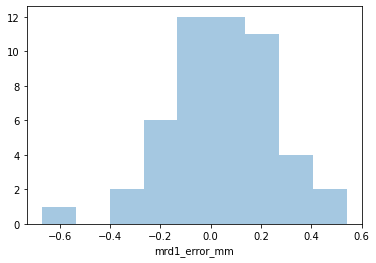

In [ ]:
print('[MRD1] Error distribution')
sns.distplot(df_comparison_results.mrd1_error_mm, kde = False)

[MRD1] ABSOLUTE Error distribution


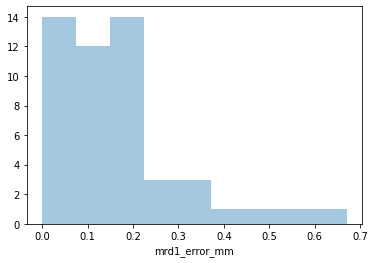

In [ ]:
print('[MRD1] ABSOLUTE Error distribution')
sns.distplot(abs(df_comparison_results.mrd1_error_mm), kde = False)

In [ ]:
print('[MRD2] Number measurement with greater than 0.4 mm error:', sum(abs(df_comparison_results.mrd2_error_mm) > 0.4), '(out of', \
        str(df_comparison_results.shape[0]) + ')')

[MRD2] Number measurement with greater than 0.4 mm error: 16 (out of 50)


In [ ]:
print('[MRD2] Number measurement with greater than 0.3 mm error:', sum(abs(df_comparison_results.mrd2_error_mm) > 0.3), '(out of', \
        str(df_comparison_results.shape[0]) + ')')

[MRD2] Number measurement with greater than 0.3 mm error: 19 (out of 50)


[MRD1] Error distribution


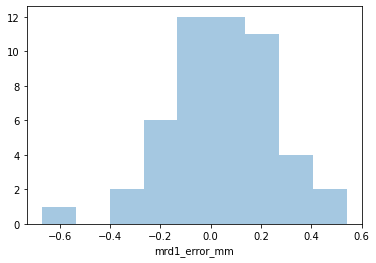

In [ ]:
print('[MRD1] Error distribution')
sns.distplot(df_comparison_results.mrd1_error_mm, kde = False)

### Average MRD1 Error over three person

In [ ]:
from functools import reduce

testing_source_lst = ['do', 'cl', 'zvi']

df_dict = {}
for testing_source in testing_source_lst:
    input_csv_path = file_dir + '../data/final_output/csv/' + testing_source + '.csv'
    print('[Input] Input csv dir:', input_csv_path)
    tmp_df = pd.read_csv(input_csv_path).sort_values(by = "orderred_id")
    df_dict[testing_source] = tmp_df
# comparison_merged = reduce(lambda left, right: pd.merge(left, right, on = ['orderred_id'], how = 'outer'), df_lst)

[Input] Input csv dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/csv/do.csv
[Input] Input csv dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/csv/cl.csv
[Input] Input csv dir: drive/My Drive/Dr Chao/notebooks/../data/final_output/csv/zvi.csv


In [ ]:
print('Averaging on MRD1 Error...')
measurement_df = pd.DataFrame(index = df_dict['do'].orderred_id)
# measurement_df.index = df_dict['do']
for testing_source in testing_source_lst:
    measurement_df[testing_source + '_abs'] = pd.Series(df_dict[testing_source].mrd1_error_mm.abs().values, df_dict[testing_source].orderred_id)
    measurement_df[testing_source] = pd.Series(df_dict[testing_source].mrd1_error_mm.values, df_dict[testing_source].orderred_id)
measurement_df['avg_abs'] = measurement_df.apply(lambda s: np.mean(np.array([s.do_abs, s.cl_abs, s.zvi_abs])), axis = 1)
measurement_df['avg'] = measurement_df.apply(lambda s: np.mean(np.array([s.do, s.cl, s.zvi])), axis = 1)

Averaging on MRD1 Error...


In [ ]:
measurement_df.head()

,do_abs,do,cl_abs,cl,zvi_abs,zvi,avg_abs,avg
orderred_id,,,,,,,,
1,0.40,0.40,0.35,0.35,0.50,0.50,0.416667,0.416667
3,0.18,0.18,0.09,-0.09,0.05,0.05,0.106667,0.046667
7,0.18,0.18,0.23,0.23,0.60,0.60,0.336667,0.336667
10,0.16,-0.16,0.10,-0.10,0.31,-0.31,0.190000,-0.190000
15,0.19,0.19,0.15,0.15,0.19,0.19,0.176667,0.176667


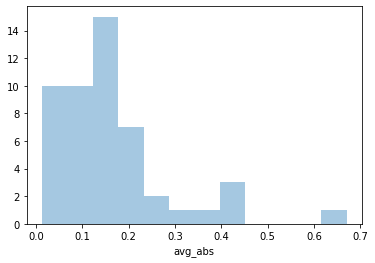

In [ ]:
sns.distplot(measurement_df.avg_abs, kde = False)

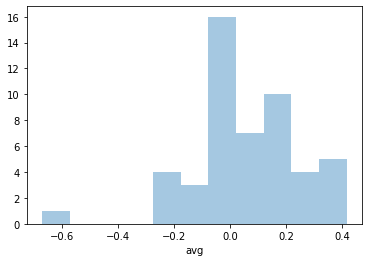

In [ ]:
sns.distplot(measurement_df.avg, kde = False)

In [ ]:
print('[MRD1] Number measurement with greater than 0.4 mm error:', sum(abs(measurement_df.avg) > 0.4), '(out of', \
        str(measurement_df.shape[0]) + ')')

[MRD1] Number measurement with greater than 0.4 mm error: 4 (out of 50)


In [ ]:
print('[MRD1] Number measurement with greater than 0.3 mm error:', sum(abs(measurement_df.avg) > 0.3), '(out of', \
        str(measurement_df.shape[0]) + ')')

[MRD1] Number measurement with greater than 0.3 mm error: 6 (out of 50)


In [ ]:
measurement_df.to_csv('Summary_comparison_mrd1.csv', index = False)